# **Loading Libraries**

In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# **Define Variables and Paths**

In [2]:
batch_size = 32
epochs = 500
channels = 3
img_height = 128
img_width = 128
learning_rate = 0.00001
class_mode = 'categorical'
# train_dir = '/kaggle/working//train'
# val_dir = '/kaggle/working/val'
# test_dir = '/kaggle/working/test'

TRAIN_DIR = '/kaggle/working//train'
TEST_DIR = '/kaggle/working//test'
#BATCH_SIZE = 32
#NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (128, 128, 3)
#CLASS_MODE = 'sparse'
#CLASS_MODE = 'categorical'

print("done")

done


# **Data Exploration**

In [3]:
DATASET = "/kaggle/input/nasc-tg2-rgb/RGB"

LABELS = os.listdir(DATASET)
print(LABELS)

['rectangularfarmland', 'cloud', 'mountain', 'river', 'residential', 'beach', 'circularfarmland', 'snowberg', 'desert', 'forest']


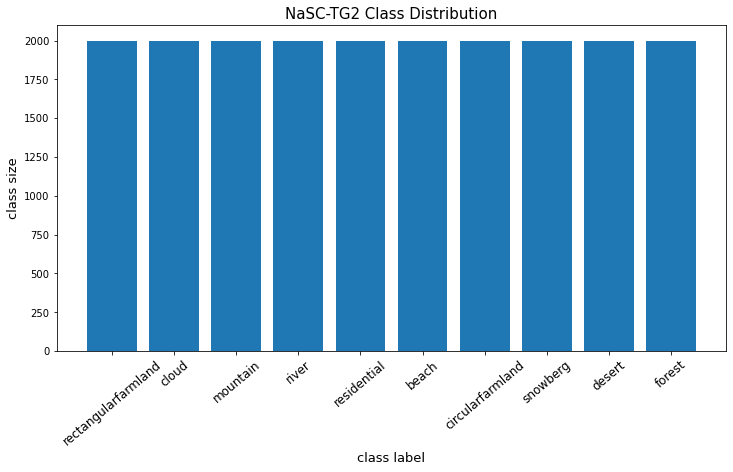

In [4]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('NaSC-TG2 Class Distribution', fontsize=15);

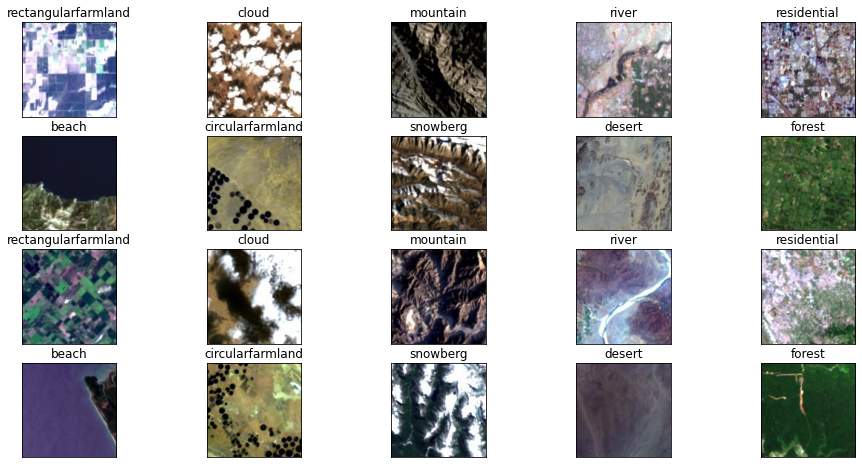

In [5]:
img_paths = [os.path.join(DATASET, l + '/' + l +'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l + '/'+ l +'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(16, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

# **Train/Test Split Folder**

In [6]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator


# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [7]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))
print(X.shape)
print(y)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub(DATASET, '/kaggle/working/train', i) for i in train_paths]
    new_test_paths = [re.sub(DATASET, '/kaggle/working/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

(20000,)
       beach  circularfarmland  cloud  desert  forest  mountain  \
0          0                 0      0       0       0         0   
1          0                 0      0       0       0         0   
2          0                 0      0       0       0         0   
3          0                 0      0       0       0         0   
4          0                 0      0       0       0         0   
...      ...               ...    ...     ...     ...       ...   
19995      0                 0      0       0       1         0   
19996      0                 0      0       0       1         0   
19997      0                 0      0       0       1         0   
19998      0                 0      0       0       1         0   
19999      0                 0      0       0       1         0   

       rectangularfarmland  residential  river  snowberg  
0                        1            0      0         0  
1                        1            0      0         0  
2        

  0%|          | 19/16000 [00:00<01:27, 183.18it/s]

moving training files..


  0%|          | 17/4000 [00:00<00:24, 164.13it/s]

moving testing files..


100%|██████████| 4000/4000 [00:24<00:00, 161.99it/s]


# **Loading Data**

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/kaggle/working/train"
TEST_DIR = "/kaggle/working/test"

# Create a ImageDataGenerator Instance which can be used for data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    validation_split=0.2
)

train_data = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# The validation set is optional if we choose to do that
val_data = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)

Found 12800 images belonging to 10 classes.
Found 3200 images belonging to 10 classes.


# Building model

In [9]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
import keras

model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, channels))

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(10, activation= 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

print("done")

94773248/94765736 [==============================] - 1s 0us/step
done


In [10]:
from keras.optimizers import Adam
adam = Adam(lr=learning_rate)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

for layer in model.layers[:-3]:
    layer.trainable = False

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

# Running Model

In [11]:
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('ResNet.h5', save_best_only=True, monitor='val_loss', mode='min')

In [12]:
history = model.fit_generator(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    steps_per_epoch=24,
    validation_steps=10,
    callbacks=[mcp_save]
)

Epoch 1/500
24/24 [==============================] - 7s 286ms/step - loss: 3.6582 - accuracy: 0.1315 - val_loss: 2.5511 - val_accuracy: 0.1031
Epoch 2/500
24/24 [==============================] - 5s 217ms/step - loss: 3.5031 - accuracy: 0.1497 - val_loss: 2.5669 - val_accuracy: 0.1063
Epoch 3/500
24/24 [==============================] - 5s 228ms/step - loss: 3.1243 - accuracy: 0.1862 - val_loss: 2.7320 - val_accuracy: 0.0875
Epoch 4/500
24/24 [==============================] - 6s 231ms/step - loss: 2.7949 - accuracy: 0.2448 - val_loss: 3.2499 - val_accuracy: 0.1250
Epoch 5/500
24/24 [==============================] - 5s 210ms/step - loss: 2.5234 - accuracy: 0.2760 - val_loss: 4.4303 - val_accuracy: 0.1063
Epoch 6/500
24/24 [==============================] - 5s 214ms/step - loss: 2.3635 - accuracy: 0.3307 - val_loss: 7.3242 - val_accuracy: 0.1000
Epoch 7/500
24/24 [==============================] - 5s 205ms/step - loss: 2.0482 - accuracy: 0.3594 - val_loss: 10.0233 - val_accuracy: 0.106

# Plotting Metrics

In [13]:
import matplotlib.pyplot as plt

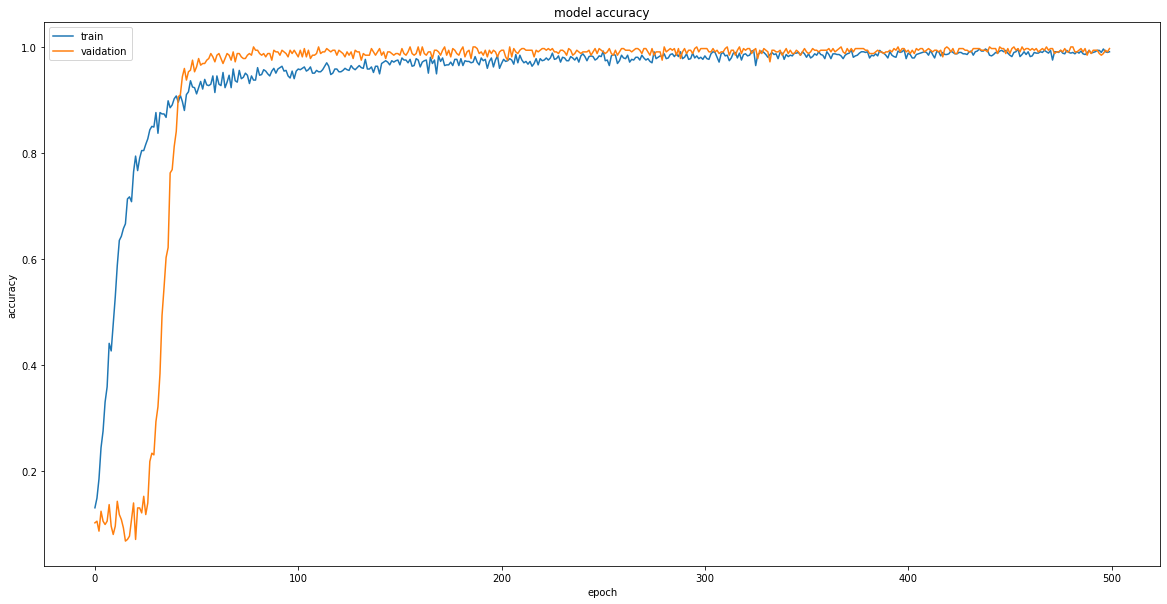

In [14]:
plt.figure(figsize = (20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaidation'], loc='upper left')
plt.show()

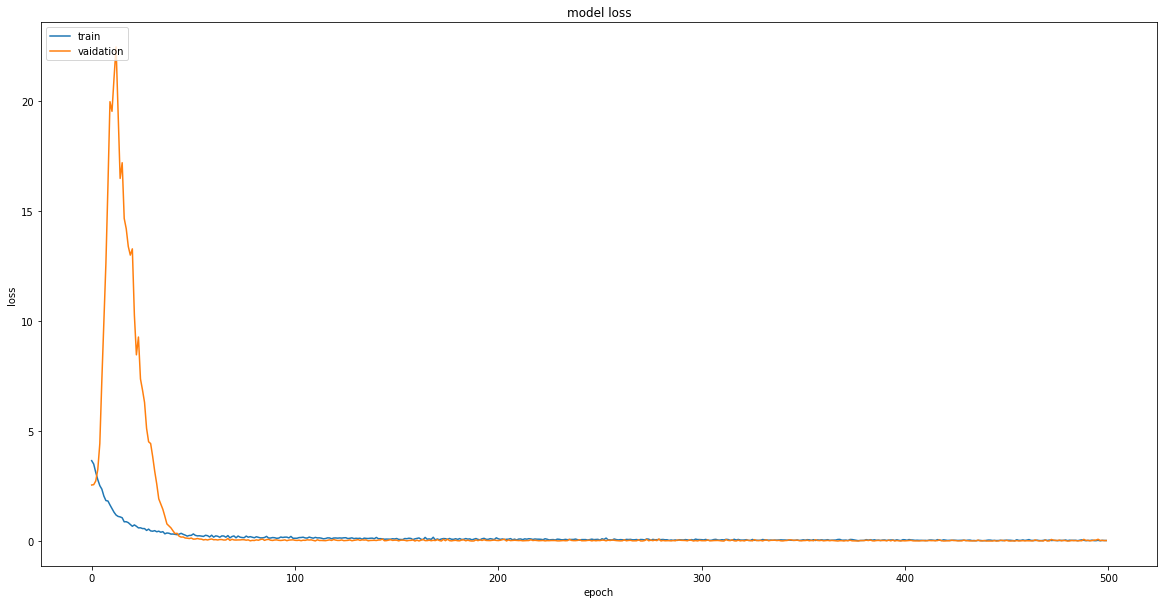

In [15]:
plt.figure(figsize = (20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaidation'], loc='upper left')
plt.show()

# Loading test data

In [16]:
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_data = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=69
)


# test_data_generator = ImageDataGenerator(
#     rescale=1./255
# )

# test_data = test_data_generator.flow_from_directory(
#     batch_size=1,
#     directory=TEST_DIR,
#     shuffle=False,
#     target_size=(img_height, img_width),
#     class_mode='categorical'
# )


idx2label_dict = {test_data.class_indices[k]: k for k in test_data.class_indices}

Found 4000 images belonging to 10 classes.


# Predicting values

In [17]:
import time 

model.load_weights('ResNet.h5')
inference_times = []
for i in range(5):
    start_time = time.time()
    y_pred = model.predict_generator(test_data, steps=4000)
    inference_time = time.time() - start_time
    inference_times.append(inference_time)
print('Average inference time: %.2f seconds' % (sum(inference_times)/len(inference_times)))
y_true = test_data.classes

Average inference time: 3.25 seconds


In [18]:
import numpy as np

y_pred = np.argmax(y_pred, axis = 1)

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [20]:
def get_key(mydict,val): 
    for key, value in mydict.items(): 
         if val == value: 
             return key 

In [21]:
def find_metrics(y_true, y_pred, idx2label_dict, class_name):
    cm = confusion_matrix(y_true, y_pred)
    out1 = np.sum(cm, axis = 1)
    out2 = np.sum(cm, axis = 0)
    id = get_key(idx2label_dict, class_name)
    r1 = cm[id][id]/out1[id]
    r2 = cm[id][id]/out2[id]
    s = cm[id][id]
    return (r1, r2, s)

# Precision and Recall

In [22]:
import prettytable

table = prettytable.PrettyTable(['Class', 'Recall', 'Precision', 'Accuracy', 'F1 Score'])
class_names =  ['rectangularfarmland', 'cloud', 'mountain', 'river', 'residential', 'beach', 'circularfarmland', 'snowberg', 'desert', 'forest']
sum = 0
               
cm = confusion_matrix(y_true, y_pred)
cm_sum = np.sum(cm)
col_sum = np.sum(cm, axis = 0)
row_sum = np.sum(cm, axis = 1)

class_acc = []

row = len(cm)

for x in range(0,row):
    tp = cm[x][x] 
    fp = row_sum[x] - cm[x][x]
    fn = col_sum[x] - cm[x][x]
    tn = cm_sum - row_sum[x]- col_sum[x] + cm[x][x]

    temp = (tp+tn)/(tp+fn+fp+tn)
    class_acc.append(temp)

temp = 0    
for _class in class_names:
    result1, result2, s = find_metrics(y_true, y_pred, idx2label_dict, _class)
    sum += s
    f1 = (2*(result1* result2))/ (result1 + result2)
    table.add_row([_class, round(result1, 2), round(result2, 2), round(class_acc[temp], 2), round(f1, 2)])
    temp +=1
print(table)
print("Accuracy: %.2f" % (sum/4000*100))

+---------------------+--------+-----------+----------+----------+
|        Class        | Recall | Precision | Accuracy | F1 Score |
+---------------------+--------+-----------+----------+----------+
| rectangularfarmland |  0.99  |    1.0    |   1.0    |   0.99   |
|        cloud        |  1.0   |    1.0    |   1.0    |   1.0    |
|       mountain      |  0.99  |    0.99   |   1.0    |   0.99   |
|        river        |  0.98  |    0.98   |   1.0    |   0.98   |
|     residential     |  1.0   |    0.99   |   1.0    |   1.0    |
|        beach        |  0.99  |    1.0    |   1.0    |   1.0    |
|   circularfarmland  |  1.0   |    1.0    |   1.0    |   1.0    |
|       snowberg      |  1.0   |    0.99   |   1.0    |   1.0    |
|        desert       |  0.99  |    1.0    |   1.0    |   1.0    |
|        forest       |  1.0   |    1.0    |   1.0    |   1.0    |
+---------------------+--------+-----------+----------+----------+
Accuracy: 99.48


# Confusion Matrix

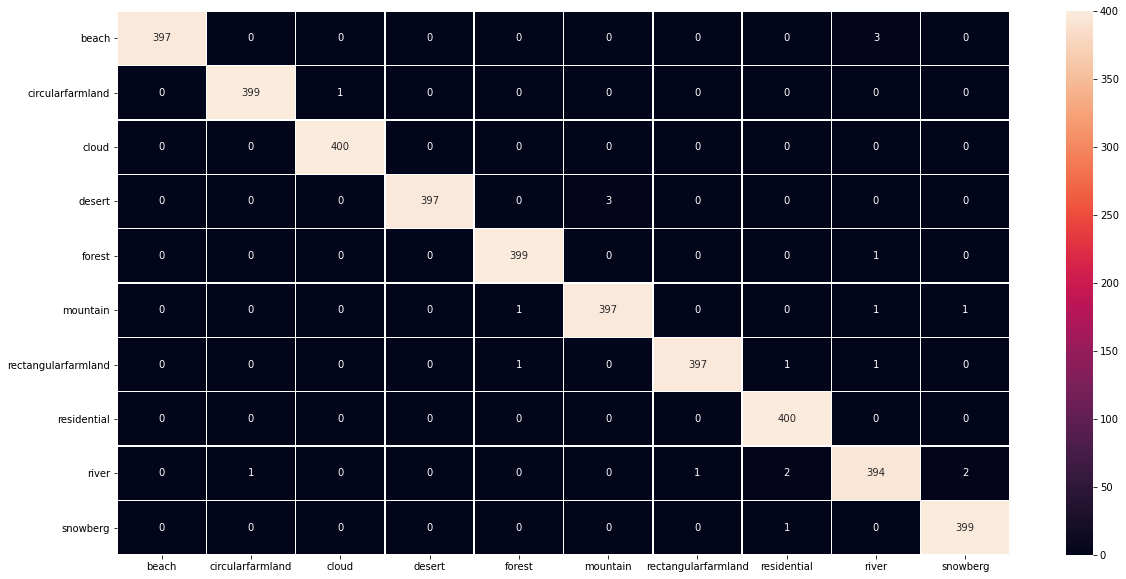

In [23]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [idx2label_dict[int(i)] for i in "0123456789"], columns = [idx2label_dict[int(i)] for i in "0123456789"])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True, linewidths=.5, fmt="d")